# Principal Component Analisys

## Segmentación diaria de los datos
En un primer momento, se planteó dividir los datos en segmentos horarios dentro de cada día con el objetivo de analizar de forma localizada cómo la alimentación afecta dinámicamente a las variables del sistema. Esta aproximación permitiría identificar patrones diarios, respuestas transitorias del proceso y eventos atípicos, además de facilitar la interpretación del análisis multivariable al reducir la variabilidad acumulada.

No obstante, al implementar esta segmentación se observó que las variables asociadas a la alimentación presentaban varianza nula, ya que su valor se mantenía constante dentro de cada día. Esta falta de variabilidad impide su inclusión en el análisis de componentes principales (PCA), cuya validez depende de la varianza entre observaciones.

Por este motivo, se optó por una nueva estrategia: consolidar el conjunto de datos a nivel diario, generando una matriz de 15 observaciones (días), donde se calcularon los valores promedio de las variables continuas monitoreadas, y se incluyeron los valores correspondientes de alimentación registrados ese día. Esta reformulación mantiene el enfoque temporal del análisis y permite aplicar el PCA de forma estadísticamente válida.

In [1]:
# ================================
# IMPORTACIÓN DE LIBRERÍAS
# ================================

# Ciencia de datos y análisis numérico
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Utilidades del sistema
import os

# Configuración de estilos por defecto
plt.style.use('ggplot')
pio.templates.default = 'ggplot2'

In [2]:
# ================================
# CARGA Y EXPLORACIÓN DE DATOS
# ================================

# Carga del dataset consolidado a nivel diario
data = pd.read_csv('../Data/data_pca.csv')

print(f"Dimensiones del dataset: {data.shape}")
print(f"Variables disponibles: {list(data.columns)}")
data

Dimensiones del dataset: (15, 14)
Variables disponibles: ['dia', 'time', 'agitación', 'CH4', 'CO2', 'gas_out', 'pH', 'EV', 'RFV', 'Temperatura', 'TRH', 'RFV_SV', 'EV_SV', 'TCO']


,dia,time,agitación,CH4,CO2,gas_out,pH,EV,RFV,Temperatura,TRH,RFV_SV,EV_SV,TCO
0,1,41:42.7,1,65.76,4.16,1,7.02,192,0,22.39,60,0.00,13.59,1.18
1,2,42:24.5,1,233.36,3.19,1,7.04,135,67,22.80,57,4.42,9.55,1.22
2,3,08:40.9,1,326.64,4.98,1,6.95,106,106,23.49,54,7.00,7.50,1.26
3,4,06:30.7,1,296.15,4.09,1,7.43,75,150,24.69,51,9.90,5.31,1.32
4,5,15:59.3,1,245.89,2.75,1,7.22,0,240,25.34,48,15.84,0.00,1.38
5,6,00:27.3,1,90.90,3.15,1,7.20,85,170,25.60,45,11.22,6.01,1.50
6,7,08:00.2,1,182.28,2.52,1,7.07,120,120,25.78,48,7.92,8.49,1.43
7,8,02:13.4,1,181.42,4.65,1,7.31,151,74,25.74,51,4.89,10.68,1.35
8,9,29:43.3,1,44.95,3.51,1,7.80,213,0,25.71,54,0.00,15.07,1.31
9,10,03:16.3,1,139.73,6.17,1,7.39,135,67,25.94,57,4.42,9.55,1.22


In [3]:
# ================================
# PREPROCESAMIENTO DE DATOS
# ================================

# Definimos las columnas a excluir del análisis PCA
# - 'dia', 'time': variables identificadoras
# - 'agitación', 'gas_out': variables con varianza nula (valores constantes)
excluded_columns = ['dia', 'time', 'agitación', 'gas_out']

# Seleccionamos solo las variables numéricas relevantes para PCA
numeric_data = data.drop(columns=excluded_columns)
print(f"Variables incluidas en PCA: {list(numeric_data.columns)}")

# Estandarización: media=0, desviación estándar=1
# Esto es crítico en PCA para evitar que variables con mayor escala dominen el análisis
scaler = StandardScaler()
data_scaled = scaler.fit_transform(numeric_data)

Variables incluidas en PCA: ['CH4', 'CO2', 'pH', 'EV', 'RFV', 'Temperatura', 'TRH', 'RFV_SV', 'EV_SV', 'TCO']


Varianza explicada por los primeros 3 componentes: 84.5%
Figuras guardadas en: ../Figures/varianza_pca.png, ../Figures/varianza_pca.svg


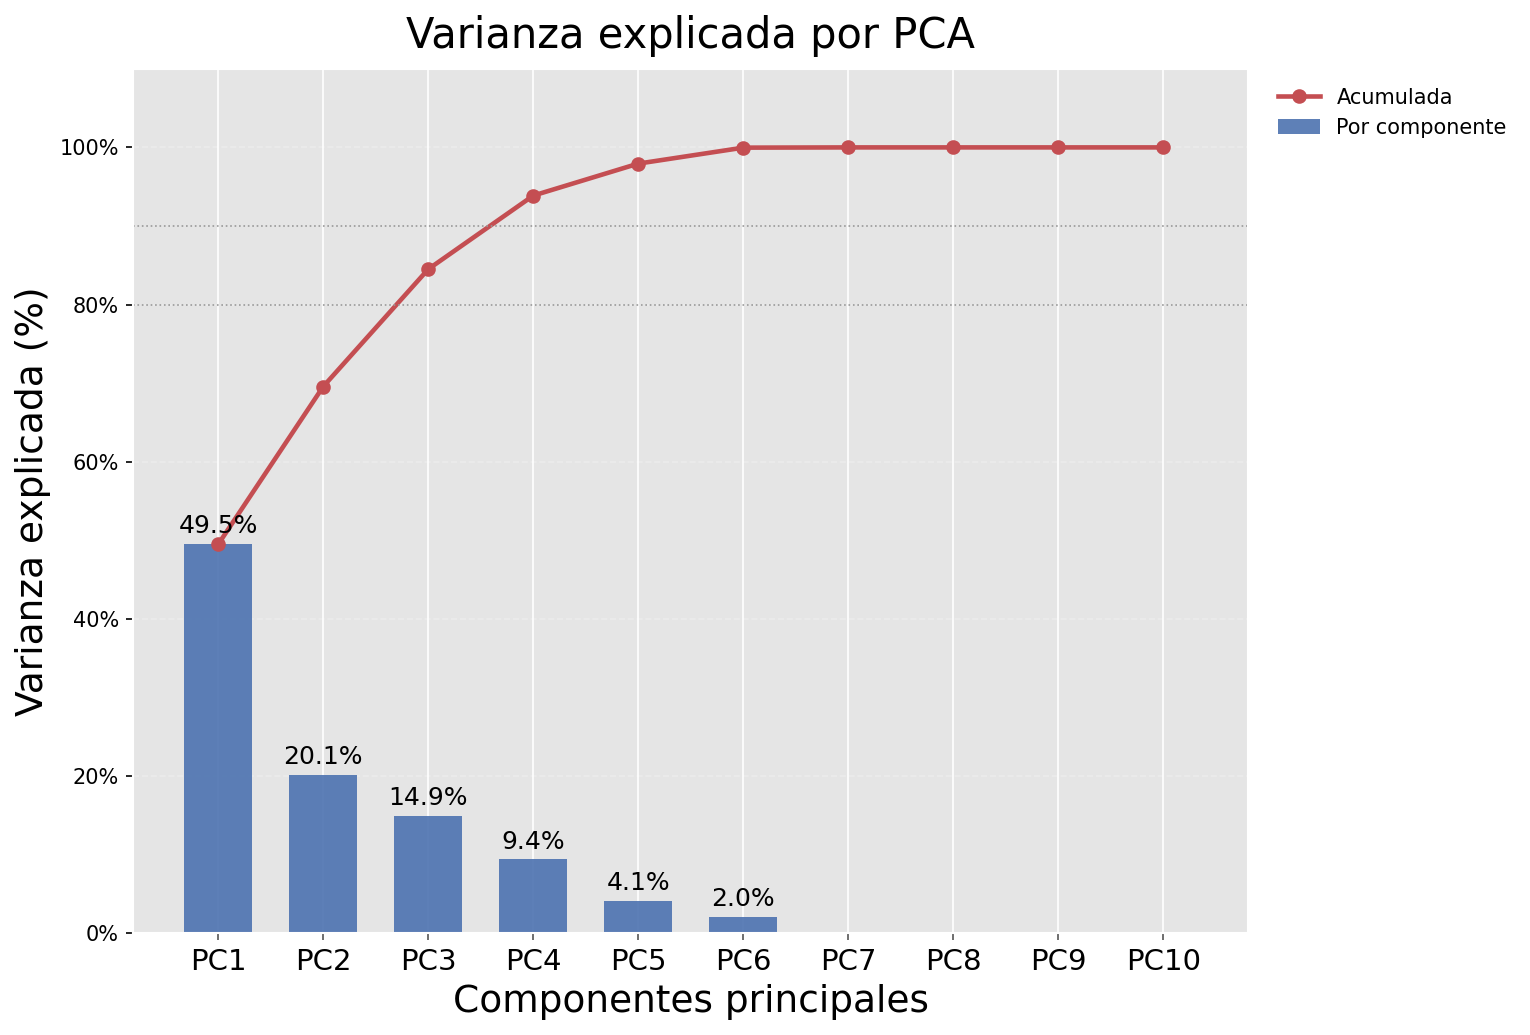

In [4]:
# ================================
# ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
# ================================

# Aplicamos PCA con todos los componentes para análisis completo de varianza
pca_full = PCA()
principal_components_full = pca_full.fit_transform(data_scaled)

# Cálculo de varianza explicada (en porcentaje)
explained_variance = pca_full.explained_variance_ratio_ * 100
explained_variance_cumsum = np.cumsum(explained_variance)

print(f"Varianza explicada por los primeros 3 componentes: {explained_variance_cumsum[2]:.1f}%")

# ================================
# VISUALIZACIÓN: VARIANZA EXPLICADA
# ================================

# Preparación de datos para visualización
n_components = len(explained_variance)
pcs = [f'PC{i+1}' for i in range(n_components)]
x = np.arange(n_components)
bar_width = 0.65

# Configuración de la figura
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

# Gráfico de barras: varianza por componente
bars = ax.bar(x, explained_variance, width=bar_width, color='#4C72B0', 
              alpha=0.9, label='Por componente')

# Línea: varianza acumulada
line = ax.plot(x, explained_variance_cumsum, color='#C44E52', marker='o', 
               lw=2.2, label='Acumulada')[0]

# Etiquetas sobre barras (solo para valores significativos > 2%)
for i, v in enumerate(explained_variance):
    if v >= 2:
        ax.text(i, v + max(explained_variance)*0.015, f'{v:.1f}%', 
                ha='center', va='bottom', fontsize=12)

# Configuración de ejes y formato
color = "#000000"
ax.set_xticks(x)
ax.set_xticklabels(pcs, fontsize=14, rotation=0, color=color)
ax.set_ylabel('Varianza explicada (%)', fontsize=18, color=color)
ax.set_xlabel('Componentes principales', fontsize=18, color=color)
ax.set_title('Varianza explicada por PCA', fontsize=20, pad=10, color=color)
ax.tick_params(axis='y', colors=color)

# Configuración del rango y formato
ymax = min(110, max(110, explained_variance_cumsum[-1]))
ax.set_ylim(0, ymax)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
ax.grid(axis='y', linestyle='--', alpha=0.25)

# Líneas de referencia (80% y 90%)
for threshold, col in [(80, '0.6'), (90, '0.6')]:
    if explained_variance_cumsum[-1] >= threshold:
        ax.axhline(threshold, color=col, lw=0.8, ls=':')

# Leyenda y ajuste de layout
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)
plt.tight_layout(rect=[0, 0, 0.86, 1])

# Guardar figuras en alta resolución
os.makedirs('../Figures', exist_ok=True)
output_files = ['../Figures/varianza_pca.png', '../Figures/varianza_pca.svg']
for output_file in output_files:
    fig.savefig(output_file, dpi=300 if output_file.endswith('.png') else None, 
                bbox_inches='tight')

print(f'Figuras guardadas en: {", ".join(output_files)}')
plt.show()

**¿Qué es la varianza explicada?**

La **varianza explicada** se refiere a la proporción de la variabilidad total de los datos que es capturada por cada componente principal. Cada componente principal es una combinación lineal de las variables originales y está diseñado para maximizar la varianza explicada.

En términos simples:

- **Varianza explicada por un componente principal**: Indica cuánta información (o dispersión) de los datos originales es capturada por ese componente.
- **Varianza acumulada**: Es la suma de la varianza explicada por los componentes principales seleccionados, lo que indica cuánta información total de los datos originales se conserva al usar esos componentes.

Por ejemplo, si el primer componente principal explica el 60% de la varianza y el segundo explica el 25%, entonces juntos explican el 85% de la variabilidad total de los datos. Esto significa que los dos primeros componentes principales capturan la mayor parte de la información de los datos originales.

**¿Por qué hay un componente por cada variable?**

PCA transforma tu matriz de datos original (de dimensión 𝑛 × 𝑝 donde 𝑝 = 10 (p= 10 variables) en un nuevo sistema de coordenadas con 𝑝 componentes principales. 
Estos componentes:

* Son combinaciones lineales ortogonales (no correlacionadas) de las variables originales.

* Están ordenados por la cantidad de varianza explicada, es decir, cuánto de la información (dispersión) original captura cada uno.

[Leer más](../../SNIQBA/Notas/nota%201.md)

Cargas de los componentes principales:
      PC1   PC2   PC3   PC4   PC5   PC6  PC7  PC8  PC9  PC10
CH4  0.32 -0.29  0.86  0.20  0.17  0.29  0.0  0.0  0.0   0.0
CO2 -0.55 -0.07  0.46  0.63 -0.36 -0.16 -0.0 -0.0  0.0  -0.0
pH  -0.31  0.70 -0.11  0.52  0.44 -0.08  0.0  0.0 -0.0  -0.0
EV  -0.96  0.31  0.10 -0.17 -0.04  0.07  0.0  0.0 -0.0   0.0
RFV  1.03 -0.08  0.01  0.08  0.01 -0.08  0.0  0.0  0.0   0.0
Figuras guardadas en: ../Figures/cargas_pca.png, ../Figures/cargas_pca.svg


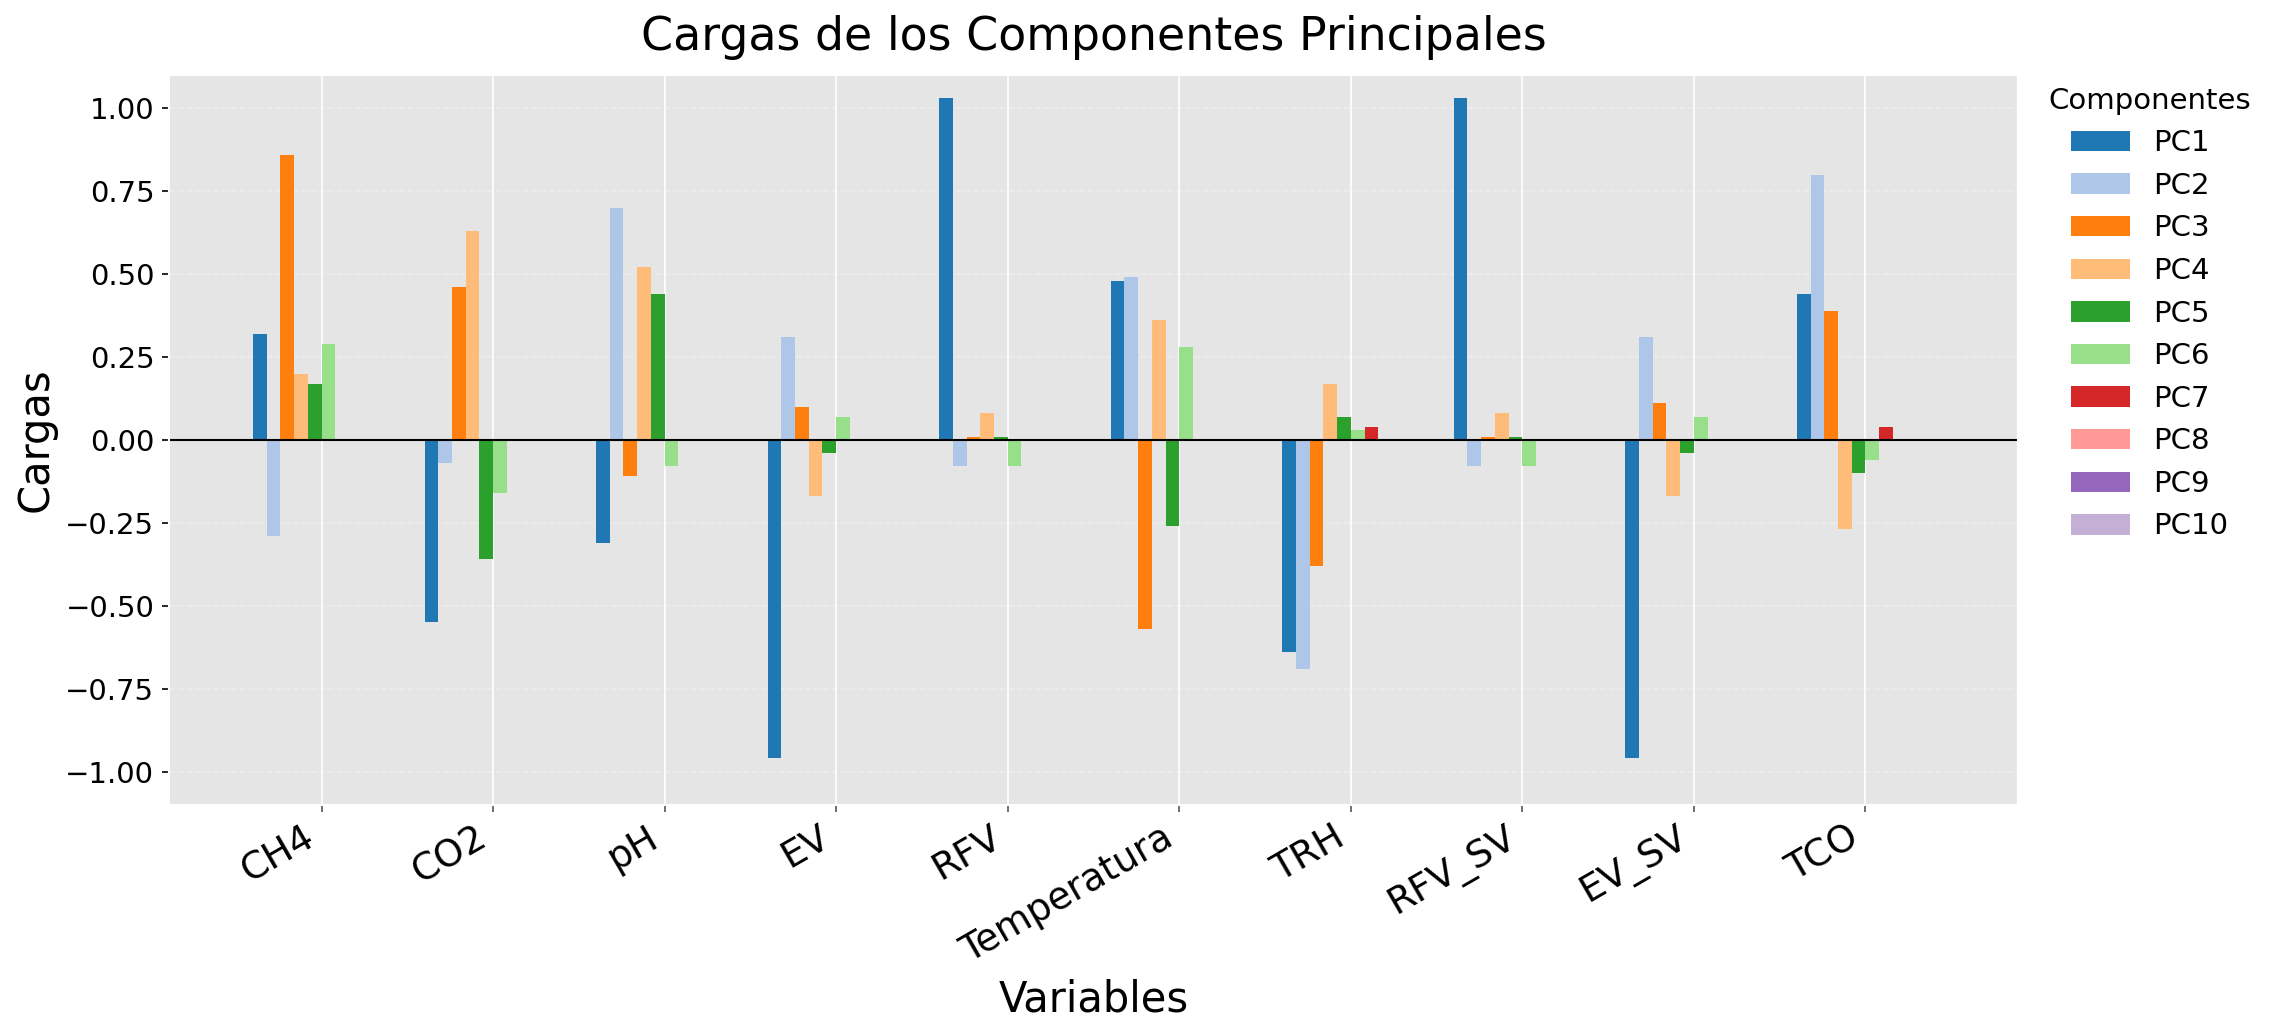

In [13]:
# ================================
# ANÁLISIS DE CARGAS (LOADINGS)
# ================================

# Cálculo de las cargas: contribución de cada variable a los componentes principales
# Escalamos por la raíz de los eigenvalues para interpretación correcta
loadings = pca_full.components_.T * np.sqrt(pca_full.explained_variance_)
variables = numeric_data.columns
loadings_df = pd.DataFrame(
    loadings, 
    columns=[f'PC{i+1}' for i in range(loadings.shape[1])], 
    index=variables
).round(2)

print("Cargas de los componentes principales:")
print(loadings_df.head())

# ================================
# VISUALIZACIÓN: CARGAS DE LOS COMPONENTES PRINCIPALES
# ================================

# Configuración dinámica para el gráfico
n_pcs = len(loadings_df.columns)
n_vars = len(loadings_df.index)
bar_width = min(0.8 / n_pcs, 0.2)  # Ancho dinámico para evitar solapamiento
x = np.arange(n_vars)

# Paleta de colores para distinguir componentes
colors = plt.cm.tab20.colors

# Configuración de la figura
fig, ax = plt.subplots(figsize=(18, 7), dpi=150)

# Creación del gráfico de barras agrupadas
for i, pc in enumerate(loadings_df.columns):
    ax.bar(x + i * bar_width, loadings_df[pc], width=bar_width, 
           label=pc, color=colors[i % len(colors)])

# Configuración de ejes
ax.set_xticks(x + bar_width * (n_pcs - 1) / 2)
ax.set_xticklabels(loadings_df.index, fontsize=18, rotation=30, 
                   ha='right', color=color)
ax.tick_params(axis='y', labelsize=14, colors=color)
ax.set_ylabel('Cargas', fontsize=20, color=color)
ax.set_xlabel('Variables', fontsize=20, color=color)
ax.set_title('Cargas de los Componentes Principales', fontsize=22, 
             pad=12, color=color)

# Configuración de escala simétrica y línea base
y_lim = float(np.ceil(np.max(np.abs(loadings_df.values)) * 10) / 10) if loadings_df.values.size else 1
ax.set_ylim(-y_lim, y_lim)
ax.axhline(0, color='black', linewidth=1)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Leyenda y ajuste de layout
legend = ax.legend(title='Componentes', fontsize=14, title_fontsize=14, 
                  loc='upper left', bbox_to_anchor=(1.01, 1), 
                  borderaxespad=0., frameon=False)
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Guardar figuras en alta resolución
output_files = ['../Figures/cargas_pca.png', '../Figures/cargas_pca.svg']
for output_file in output_files:
    fig.savefig(output_file, dpi=300 if output_file.endswith('.png') else None, 
                bbox_inches='tight')

print(f'Figuras guardadas en: {", ".join(output_files)}')
plt.show()

Las **cargas**  representan la contribución de cada variable original a los componentes principales. Matemáticamente, son los coeficientes de las combinaciones lineales que forman cada componente principal.

En términos simples:

- Cada componente principal es una combinación lineal de las variables originales.
- Las cargas indican cuánto influye cada variable en un componente principal.
- Valores altos (positivos o negativos) de las cargas indican que la variable tiene una fuerte influencia en ese componente.

Por ejemplo, si una variable tiene una carga alta en el primer componente principal (PC1), significa que esa variable contribuye significativamente a la varianza explicada por PC1.

Las cargas también ayudan a interpretar los componentes principales, ya que muestran qué variables están más asociadas con cada componente.

Biplot guardado en: ../Figures/biplot_pca.png, ../Figures/biplot_pca.svg


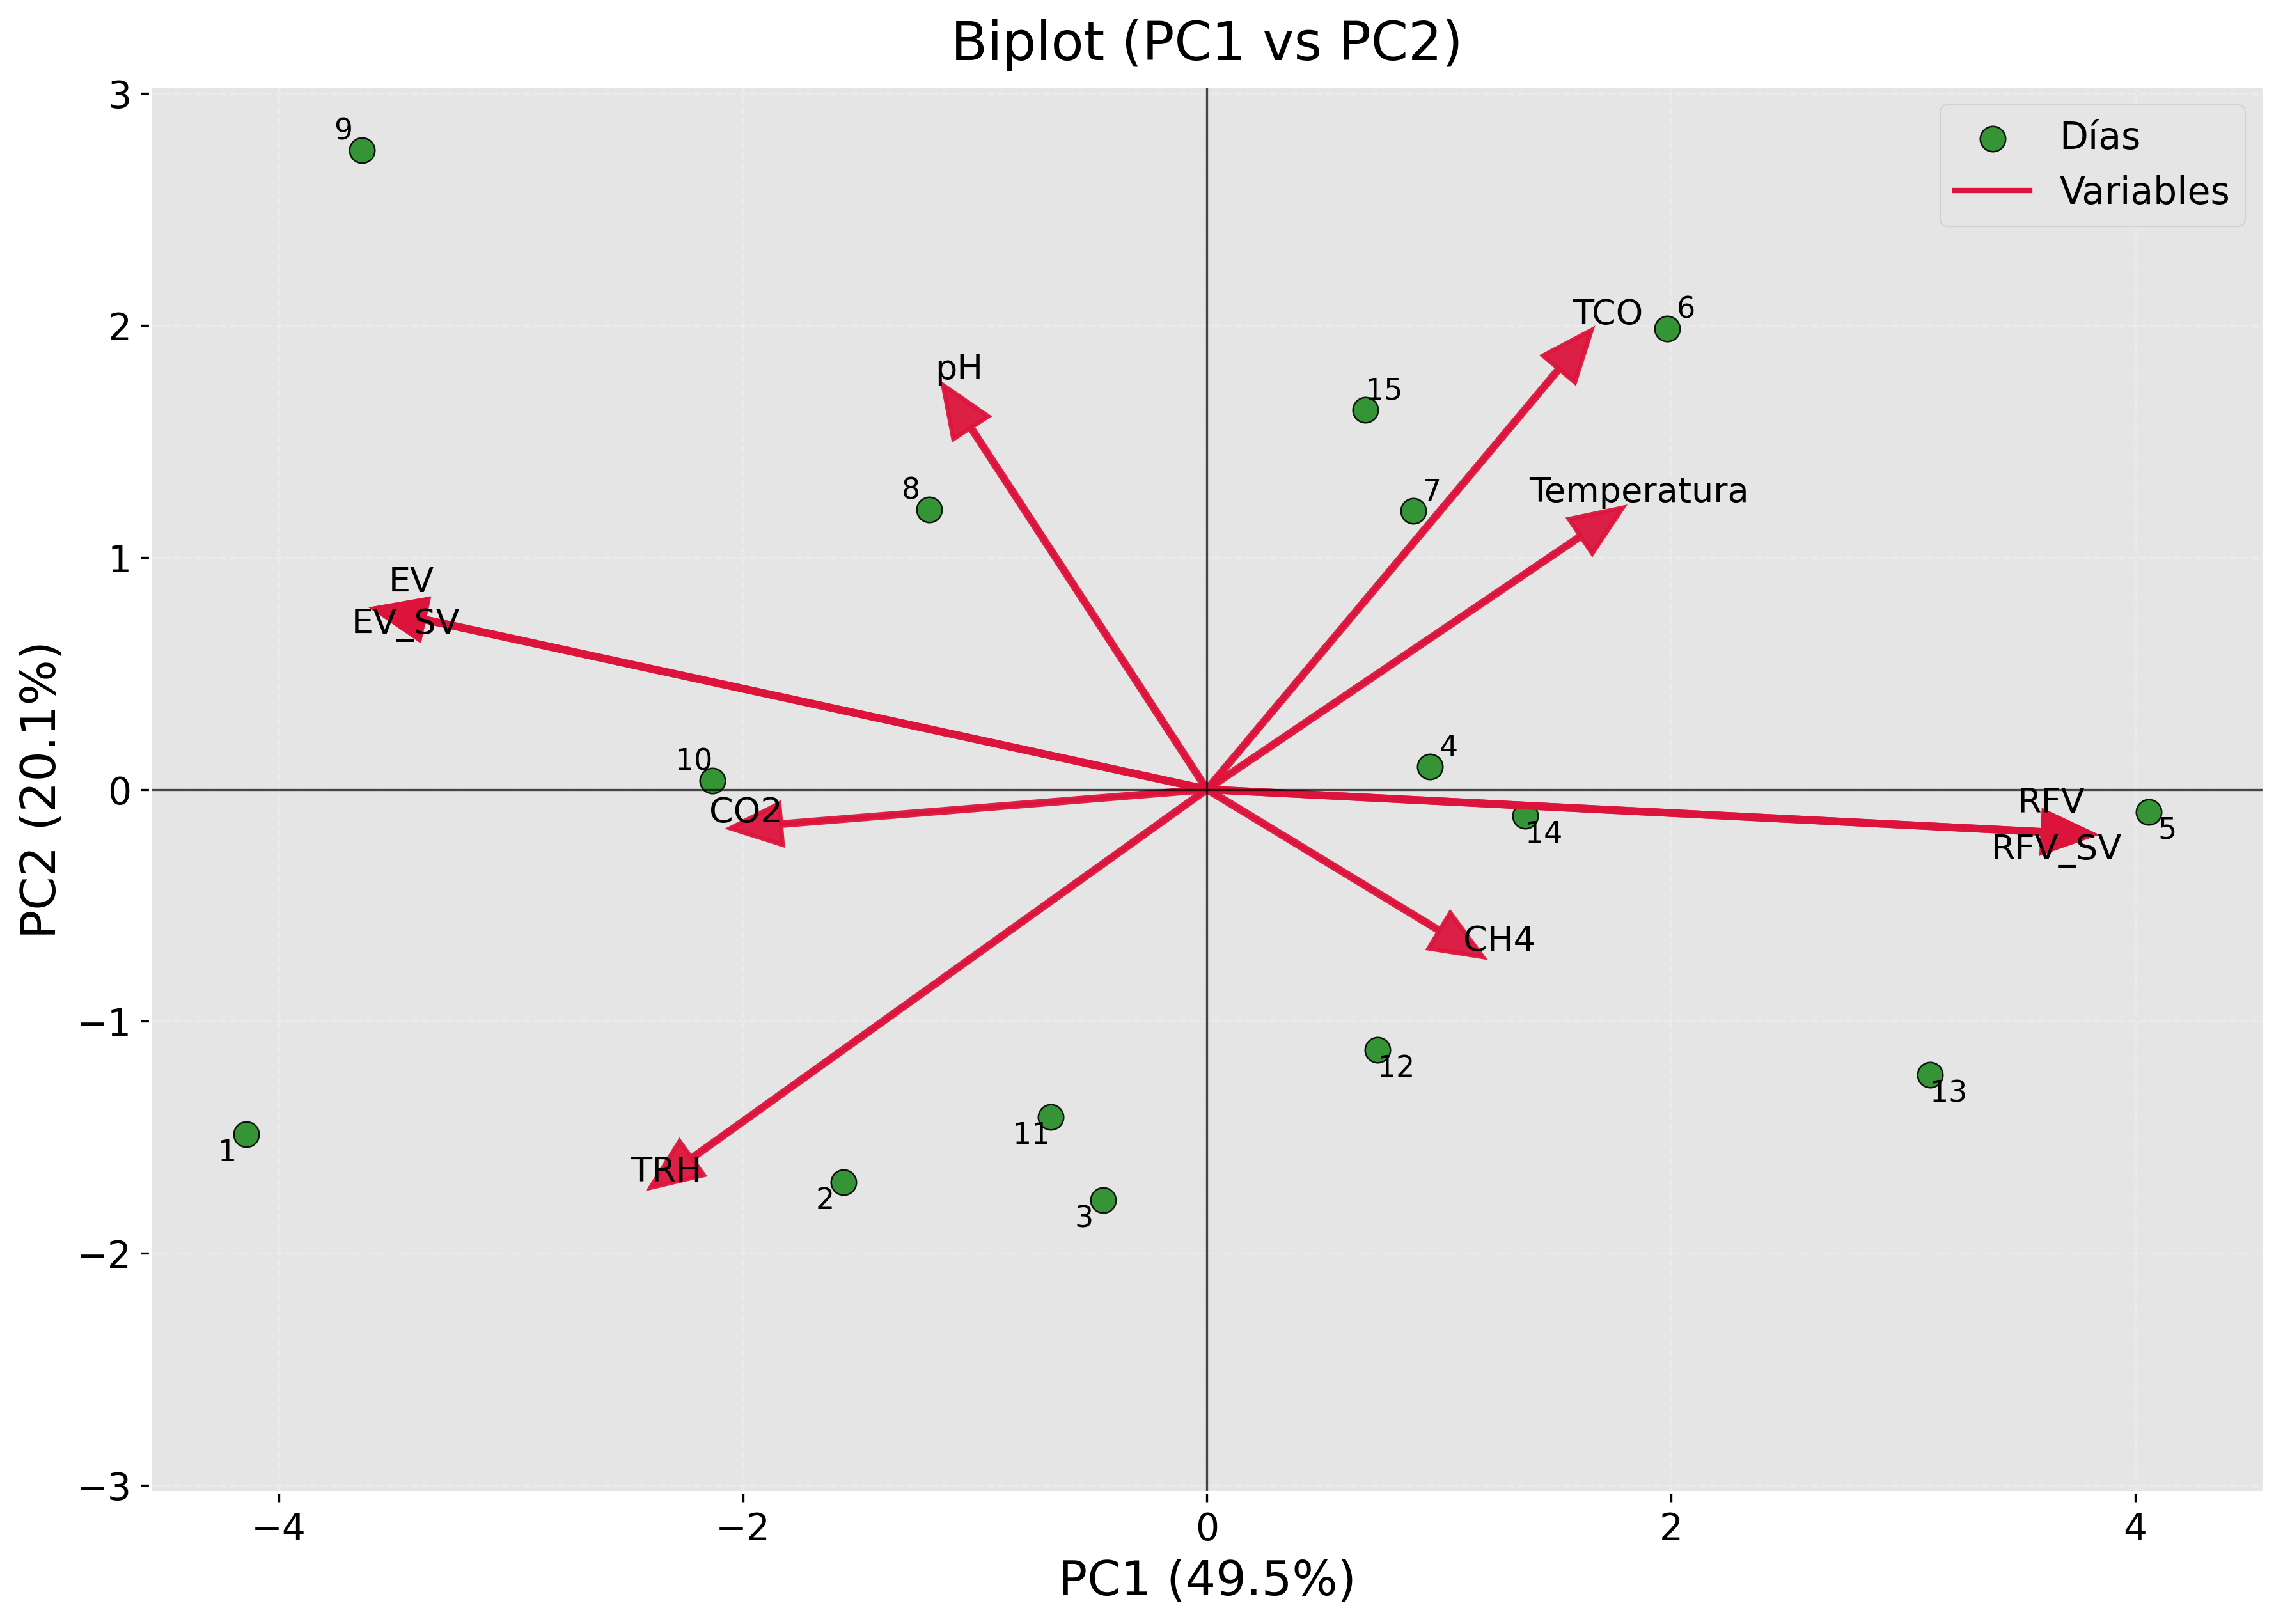

In [6]:
# ================================
# BIPLOT: VISUALIZACIÓN EN 2D
# ================================

# Aplicamos PCA reducido a 2 componentes principales para visualización
pca_2d = PCA(n_components=2)
scores_2d = pca_2d.fit_transform(data_scaled)

# Cálculo de loadings escalados para el biplot
# Escalamos por sqrt(eigenvalues) para magnitud interpretable
loadings_2d = (pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_))[:, :2]

# Escalas para mantener las flechas dentro del rango de los scores
scale_x = 0.9 * np.max(np.abs(scores_2d[:, 0]))
scale_y = 0.9 * np.max(np.abs(scores_2d[:, 1]))
vec_x = loadings_2d[:, 0] * scale_x
vec_y = loadings_2d[:, 1] * scale_y

# ================================
# CONSTRUCCIÓN DEL BIPLOT
# ================================

fig, ax = plt.subplots(figsize=(12, 9), dpi=300)

# Puntos representando los días
scatter = ax.scatter(scores_2d[:, 0], scores_2d[:, 1],
                    s=90, c='forestgreen', edgecolor='black', linewidth=0.6,
                    alpha=0.9, label='Días')

# Etiquetas de los días con offset dinámico para evitar solapamiento
dia_labels = data['dia'].astype(str).tolist() if 'dia' in data.columns else [str(i+1) for i in range(len(scores_2d))]
for (x, y), label in zip(scores_2d[:, :2], dia_labels):
    # Offset según cuadrante para reducir solapes
    ox = 7 if x >= 0 else -7
    oy = 7 if y >= 0 else -7
    ax.annotate(label, xy=(x, y), xytext=(ox, oy),
                textcoords='offset points', ha='center', va='center',
                fontsize=11, color='black')

# Vectores de variables (flechas rojas)
features = list(numeric_data.columns)
for i, feat in enumerate(features):
    ax.arrow(0, 0, vec_x[i], vec_y[i],
             color='crimson', alpha=0.95, width=0.015, length_includes_head=True,
             head_width=0.18, head_length=0.22, linewidth=1.6)

# Configuración de offsets personalizados para etiquetas que se solapan
offsets = {
    'EV': (14, 10),
    'RFV': (-16, 12),
    'EV_SV': (12, -6),
    'RFV_SV': (-14, -6),
}
default_offset = (6, 6)

# Etiquetas de variables
for i, feat in enumerate(features):
    ox, oy = offsets.get(feat, default_offset)
    ax.annotate(feat, xy=(vec_x[i], vec_y[i]),
                xytext=(ox, oy), textcoords='offset points',
                ha='center', va='center', fontsize=13, color='black')

# ================================
# CONFIGURACIÓN DEL GRÁFICO
# ================================

# Etiquetas de ejes con varianza explicada
pc1_var = pca_2d.explained_variance_ratio_[0] * 100
pc2_var = pca_2d.explained_variance_ratio_[1] * 100
ax.set_xlabel(f'PC1 ({pc1_var:.1f}%)', fontsize=18, color='black')
ax.set_ylabel(f'PC2 ({pc2_var:.1f}%)', fontsize=18, color='black')

# Configuración de límites y aspecto
x_lim = 1.1 * np.max(np.abs(scores_2d[:, 0]))
y_lim = 1.1 * np.max(np.abs(scores_2d[:, 1]))
ax.set_xlim(-x_lim, x_lim)
ax.set_ylim(-y_lim, y_lim)

# Líneas de referencia y grilla
ax.axhline(0, color='black', linewidth=0.8, alpha=0.7)
ax.axvline(0, color='black', linewidth=0.8, alpha=0.7)
ax.grid(True, linestyle='--', alpha=0.25)
ax.set_aspect('equal', adjustable='box')

# Título y configuración de ticks
ax.set_title('Biplot (PC1 vs PC2)', fontsize=20, pad=10, color='black')
ax.tick_params(axis='both', which='both', labelsize=14, colors='black')

# Leyenda
var_proxy = Line2D([0], [0], color='crimson', lw=2)
legend = ax.legend(handles=[scatter, var_proxy],
                   labels=['Días', 'Variables'],
                   loc='best', frameon=True, fancybox=True, fontsize=14)
plt.setp(legend.get_texts(), color='black')

plt.tight_layout()

# Guardar figuras en alta resolución
output_files = ['../Figures/biplot_pca.png', '../Figures/biplot_pca.svg']
for output_file in output_files:
    fig.savefig(output_file, dpi=300 if output_file.endswith('.png') else None, 
                bbox_inches='tight')

print(f'Biplot guardado en: {", ".join(output_files)}')
plt.show()

Un **biplot**  es una representación gráfica que combina dos tipos de información:

1. **Proyecciones de las observaciones**: Muestra cómo los datos originales (observaciones) se proyectan en el espacio de los componentes principales (ejes PC1, PC2, etc.). Esto permite visualizar la distribución de las observaciones en función de las nuevas dimensiones creadas por el PCA.

2. **Vectores de las variables originales**: Representa las variables originales como vectores (flechas) en el mismo espacio. La dirección y longitud de las flechas indican cómo las variables contribuyen a los componentes principales.

**¿Para qué sirve el biplot?**

- **Interpretación de los componentes principales**: Ayuda a entender qué variables originales tienen mayor influencia en cada componente principal.
- **Relaciones entre variables**: Permite identificar correlaciones entre variables. Por ejemplo, si dos flechas están cerca, las variables están correlacionadas.
- **Agrupación de observaciones**: Facilita la identificación de patrones o agrupaciones en los datos proyectados.
- **Reducción de dimensionalidad**: Visualiza datos de alta dimensionalidad en un espacio reducido (2D o 3D) para facilitar su análisis.

In [15]:
# ================================
# ANÁLISIS 3D CON CLUSTERING
# ================================

# Aplicamos PCA a 3 componentes para visualización tridimensional
pca_3d = PCA(n_components=3)
components_3d = pca_3d.fit_transform(data_scaled)

# Cálculo de varianza explicada para los 3 componentes
var_3d = pca_3d.explained_variance_ratio_ * 100
total_var_3d = var_3d.sum()

print(f"Varianza explicada por PC1-PC3: {var_3d}")
print(f"Varianza total explicada (3 componentes): {total_var_3d:.2f}%")

# ================================
# ANÁLISIS DE CLUSTERING
# ================================

# Aplicamos K-means clustering en el espacio de 3 componentes principales
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(components_3d)

# Preparación del DataFrame para Plotly
df3 = pd.DataFrame(components_3d, columns=['PC1', 'PC2', 'PC3'])
df3['Cluster'] = clusters.astype(str)
df3['Dia'] = data['dia'].astype(str) if 'dia' in data.columns else np.arange(1, len(df3)+1).astype(str)

print(f"Distribución de días por cluster:")
print(df3['Cluster'].value_counts().sort_index())

# ================================
# VISUALIZACIÓN 3D INTERACTIVA
# ================================

# Gráfico de dispersión 3D con colores por cluster
fig = px.scatter_3d(
    df3, x='PC1', y='PC2', z='PC3',
    color='Cluster', text='Dia',
    opacity=0.95,
    hover_data={'Dia': True, 'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f'},
    title=f'PCA 3D con Clustering (Varianza total: {total_var_3d:.2f}%)'
)

# Configuración de estilo de puntos y etiquetas
fig.update_traces(
    marker=dict(size=8, line=dict(width=0.6, color='white'), showscale=False),
    textposition='top center',
    textfont=dict(size=12, color='black')
)

# Cálculo y visualización de centroides por cluster
centers = df3.groupby('Cluster')[['PC1', 'PC2', 'PC3']].mean().reset_index()
print(f"\nCentroides de los clusters:")
print(centers)

# Añadir centroides al gráfico (opcional - comentado para evitar ruido visual)
# fig.add_trace(go.Scatter3d(
#     x=centers['PC1'], y=centers['PC2'], z=centers['PC3'],
#     mode='markers+text',
#     text=[f'Centro {c}' for c in centers['Cluster']],
#     textfont=dict(size=12, color='black'),
#     marker=dict(size=12, symbol='diamond', color='black'),
#     showlegend=False,
#     name='Centroides'
# ))

# ================================
# CONFIGURACIÓN DEL LAYOUT
# ================================

fig.update_layout(
    title_x=0.5,
    title_font=dict(color='black', size=16),
    legend_title_text='Grupo',
    legend_title_font_size=16,
    legend_title_font_color='black',
    legend_font_color='black',
    legend_font_size=14,
    width=1000, height=800,
    scene=dict(
        xaxis_title=f'PC1 ({var_3d[0]:.1f}%)',
        yaxis_title=f'PC2 ({var_3d[1]:.1f}%)',
        zaxis_title=f'PC3 ({var_3d[2]:.1f}%)',
        xaxis_title_font=dict(color='black'),
        yaxis_title_font=dict(color='black'),
        zaxis_title_font=dict(color='black'),
        xaxis_tickfont=dict(color='black'),
        yaxis_tickfont=dict(color='black'),
        zaxis_tickfont=dict(color='black'),
        aspectmode='cube'
    ),
    font=dict(size=15, color='black')
)

fig.show()

Varianza explicada por PC1-PC3: [49.48643671 20.08125244 14.93467457]
Varianza total explicada (3 componentes): 84.50%
Distribución de días por cluster:
Cluster
0    6
1    4
2    2
3    3
Name: count, dtype: int64

Centroides de los clusters:
  Cluster       PC1       PC2       PC3
0       0  1.657968  0.785475  0.472721
1       1 -2.777740  0.628787 -0.114617
2       2 -1.007379 -1.731300  1.680900
3       3  1.059303 -1.255132 -1.913218


In [8]:
# ================================
# RESUMEN DE RESULTADOS
# ================================

print("="*60)
print("RESUMEN DEL ANÁLISIS DE COMPONENTES PRINCIPALES")
print("="*60)

print(f"\n📊 DATASET:")
print(f"  • Observaciones (días): {data.shape[0]}")
print(f"  • Variables analizadas: {len(numeric_data.columns)}")
print(f"  • Variables: {', '.join(numeric_data.columns)}")

print(f"\n📈 VARIANZA EXPLICADA:")
print(f"  • PC1: {pca_2d.explained_variance_ratio_[0]*100:.1f}%")
print(f"  • PC2: {pca_2d.explained_variance_ratio_[1]*100:.1f}%")
print(f"  • PC1+PC2: {sum(pca_2d.explained_variance_ratio_)*100:.1f}%")
print(f"  • PC1+PC2+PC3: {total_var_3d:.1f}%")

print(f"\n🎯 CLUSTERING:")
print(f"  • Número de grupos identificados: {n_clusters}")
cluster_counts = df3['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"  • Grupo {cluster}: {count} días")

print(f"\n📁 ARCHIVOS GENERADOS:")
generated_files = [
    '../Figures/varianza_pca.png', '../Figures/varianza_pca.svg',
    '../Figures/cargas_pca.png', '../Figures/cargas_pca.svg',
    '../Figures/biplot_pca.png', '../Figures/biplot_pca.svg'
]
for file in generated_files:
    print(f"  • {file}")

print(f"\n✅ Análisis completado exitosamente!")
print("="*60)

RESUMEN DEL ANÁLISIS DE COMPONENTES PRINCIPALES

📊 DATASET:
  • Observaciones (días): 15
  • Variables analizadas: 10
  • Variables: CH4, CO2, pH, EV, RFV, Temperatura, TRH, RFV_SV, EV_SV, TCO

📈 VARIANZA EXPLICADA:
  • PC1: 49.5%
  • PC2: 20.1%
  • PC1+PC2: 69.6%
  • PC1+PC2+PC3: 84.5%

🎯 CLUSTERING:
  • Número de grupos identificados: 4
  • Grupo 0: 6 días
  • Grupo 1: 4 días
  • Grupo 2: 2 días
  • Grupo 3: 3 días

📁 ARCHIVOS GENERADOS:
  • ../Figures/varianza_pca.png
  • ../Figures/varianza_pca.svg
  • ../Figures/cargas_pca.png
  • ../Figures/cargas_pca.svg
  • ../Figures/biplot_pca.png
  • ../Figures/biplot_pca.svg

✅ Análisis completado exitosamente!
